# Example solution of DAT300 compulsory assignment 1

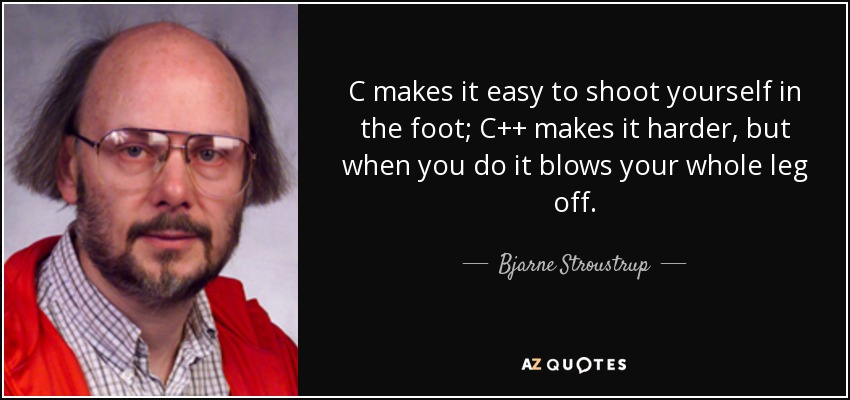

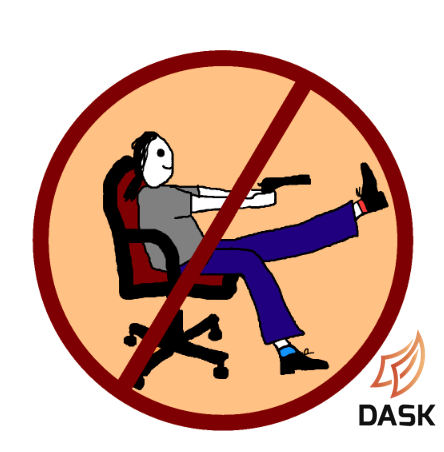

In [2]:
from os.path import join
import time

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import sklearn
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

from imblearn.ensemble import BalancedRandomForestClassifier

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster, progress
from dask import delayed
from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split, IncrementalSearchCV, GridSearchCV
from dask_ml.linear_model import LogisticRegression
from dask_ml.decomposition import PCA
import dask.array as da
from dask_ml.xgboost import XGBClassifier
from dask_ml.wrappers import Incremental

import xgboost

DATA_PATH = 'data'
TRAININIG_DATA_ARRAY = 'training_array.h5'
TESTING_DATA_ARRAY = 'testing_array.h5'

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Load and prepared the data

In [34]:
X_df_train = dd.read_csv(join(DATA_PATH, 'X_train.csv'))
y_df_train = dd.read_csv(join(DATA_PATH, 'y_train.csv'))
df_train = X_df_train.merge(y_df_train, left_index=True, right_index=True)
df_train.head()

f1        f2        f3        f4        f5        f6        f7  \
0  0.650080  0.307440  0.306270  0.186580  0.179110  0.178230  0.174430   
1  0.098689  0.090486  0.063531  0.050347  0.049322  0.039360  0.007132   
2  0.079645  0.074518  0.071149  0.052691  0.039653  0.039214  0.037016   
3  0.148200  0.101180  0.091218  0.090486  0.051666  0.038042  0.021781   
4  0.148200  0.101180  0.091218  0.089167  0.051666  0.043755  0.040093   

         f8        f9      f10  ...      f154      f155      f156      f157  \
0  0.151130  0.139410  1.83790  ...  0.119300  0.119300  0.119300  0.119300   
1 -0.016892 -0.022459 -0.31062  ...  0.040767  0.040767  0.040767 -0.003073   
2  0.029252  0.010062 -0.34840  ...  0.040767  0.040767  0.040767  0.040767   
3  0.006546 -0.008835 -0.28662  ...  0.051966  0.051966  0.051966  0.051966   
4  0.021781  0.006546 -0.38027  ...  0.051966  0.051966  0.051966  0.051966   

       f158      f159      f160      f161      f162  Target  
0  0.119300  0.119300  0.119300  0.119300  0.119300     0.0  
1 -0.003073 -0.003073 -0.003073 -0.003073 -0.003073     0.0  
2  0.040767  0.040767  0.040767  0.040767  0.040767     0.0  
3  0.051966  0.051966  0.051966  0.051966  0.051966     0.0  
4  0.051966  0.051966  0.051966  0.051966  0.051966     0.0  

[5 rows x 163 columns]

### Small remark about pandas and dask

In [40]:
y_df_pandas = y_df_train.head(100)
X_df_pandas = X_df_train.head(100)

In [45]:
cond = y_df_pandas['Target'].isnull()

In [49]:
y_df_pandas[~cond].shape

(91, 1)

In [50]:
X_df_pandas[~cond].shape

(91, 162)

##### Let's do the same stuff in Dask

In [51]:
cond = y_df_train['Target'].isnull()

In [57]:
y_df_train[~cond].compute().shape

(2858793, 1)

In [ ]:
X_df_train[~cond]

Feature Request: Dataframe reindex support #4155

https://github.com/dask/dask/issues/4155

### Read test

In [60]:
X_df_test = dd.read_csv(join(DATA_PATH, 'X_test.csv'))
X_df_test.head()

f1        f2       f3        f4        f5        f6        f7  \
0 -0.180510 -0.192210 -0.20515 -0.215250 -0.215960 -0.215960 -0.216130   
1 -0.164560 -0.180510 -0.20515 -0.205680 -0.206210 -0.215250 -0.216130   
2 -0.044046 -0.050072 -0.05787 -0.066023 -0.067086 -0.067972 -0.087645   
3  0.340010  0.329020  0.31236  0.239520  0.235090  0.189360  0.173410   
4 -0.155170 -0.168990 -0.17927 -0.218790 -0.251050 -0.252110 -0.288620   

         f8       f9       f10  ...     f153     f154     f155     f156  \
0 -0.218260 -0.22907 -0.506090  ... -0.31380 -0.16709 -0.16709 -0.16709   
1 -0.218260 -0.22907 -0.506090  ... -0.31380 -0.16006 -0.16006 -0.16006   
2 -0.099342 -0.30971  1.230800  ... -0.13746 -0.10924 -0.10924 -0.10924   
3  0.161540  0.15835 -0.038613  ...  0.38480  0.42301  0.42301  0.42301   
4 -0.325130 -0.34622 -0.324840  ... -0.28911 -0.14978 -0.14978 -0.14978   

      f157     f158     f159     f160     f161     f162  
0 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709  
1 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709 -0.16709  
2 -0.10924 -0.10924 -0.10924 -0.10924 -0.10924 -0.10924  
3  0.32402  0.32402  0.32402  0.32402  0.32402  0.32402  
4 -0.25570 -0.25570 -0.25570 -0.25570 -0.32433 -0.32433  

[5 rows x 162 columns]

### Check for NaNs

In [61]:
print(X_df_test.isnull().sum(axis=0).compute().values)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
print(df_train.isnull().sum(axis=0).compute().values)

[114491 118490 121080 130432 135668 138142 289446 292741 296966 114491
 118490 121080 130432 135668 138142 289446 292741 296966 114491 118490
 121080 130432 135668 138142 289446 292741 296966 114491 118490 121080
 130432 135668 138142 289446 292741 296966 114491 118490 121080 130432
 135668 138142 289446 292741 296966 114491 118490 121080 130432 135668
 138142 289446 292741 296966 114491 118490 121080 130432 135668 138142
 289446 292741 296966 114491 118490 121080 130432 135668 138142 289446
 292741 296966 114491 118490 121080 130432 135668 138142 289446 292741
 296966 114491 118490 121080 130432 135668 138142 289446 292741 296966
 114491 118490 121080 130432 135668 138142 289446 292741 296966 114491
 118490 121080 130432 135668 138142 289446 292741 296966 114491 118490
 121080 130432 135668 138142 289446 292741 296966 114491 118490 121080
 130432 135668 138142 289446 292741 296966 114491 118490 121080 130432
 135668 138142 289446 292741 296966 114491 118490 121080 130432 135668
 13814

In [5]:
# Drop rows with missing values for train
df_train = df_train.dropna()

Not implemented: dropna for columns ?!1

https://github.com/dask/dask/issues/4858

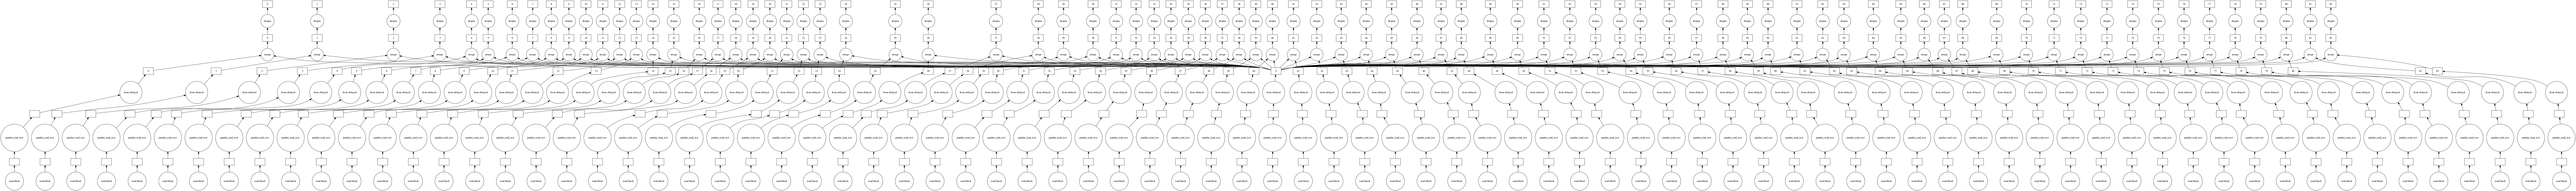

In [5]:
df_train.visualize()

## Storing to disk

In [12]:
h5py.File?

In [29]:
da.from_array?

In [17]:
h5py.File?

In [13]:
da.to_hdf5??

In [7]:
da.store??

In [2]:
# https://docs.dask.org/en/latest/array-creation.html

def writing_array(filename, dataset_name, darray, dtype=None):
    res = None
    dtype = darray.dtype if dtype is None else dtype
    with h5py.File(filename, 'a') as f: 
        d = f.require_dataset(dataset_name, shape=darray.shape,
                              dtype=dtype)
        res = da.store(darray, d, return_stored=True)[0]
    return res

def reading_array(filename, dataset_name, chunks='auto'):
    darray = None
    try:
        f = h5py.File(filename, 'r')
        darray = da.from_array(f[dataset_name], chunks=chunks)
    except:
        f.close()
    return darray


In [64]:
X_train_arr = df_train.drop(['Target'], axis=1).to_dask_array(lengths=True)
y_train_arr = df_train['Target'].to_dask_array(lengths=X_train_arr.chunks[0])

X_test_arr = X_df_test.to_dask_array(lengths=True)

In [ ]:
X_train_arr.visualize()

In [9]:
X_train_arr = writing_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'X_train',
                            X_train_arr)

In [10]:
y_train_arr = writing_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'y_train',
                            y_train_arr, dtype=np.uint8)

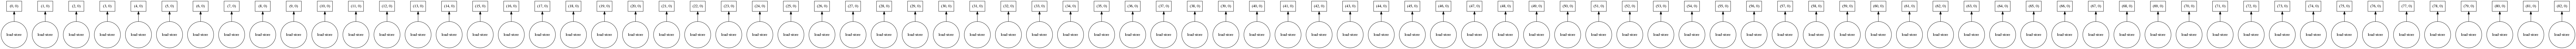

In [11]:
X_train_arr.visualize()

In [12]:
X_train_arr

dask.array<load-store-93e7d55c-f5a3-11e9-8f8c, shape=(2551335, 162), dtype=float64, chunksize=(33695, 162), chunktype=numpy.ndarray>

In [13]:
y_train_arr

dask.array<load-store-ac187974-f5a3-11e9-8f8c, shape=(2551335,), dtype=float64, chunksize=(33695,), chunktype=numpy.ndarray>

In [14]:
X_test_arr = writing_array(join(DATA_PATH, TESTING_DATA_ARRAY), 'X_test',
                           X_test_arr)

In [15]:
X_test_arr

dask.array<load-store-c17e3bfa-f5a3-11e9-8f8c, shape=(709039, 162), dtype=float64, chunksize=(36778, 162), chunktype=numpy.ndarray>

In [20]:
X_test_arr = reading_array(join(DATA_PATH, TESTING_DATA_ARRAY), 'X_test')

In [3]:
X_train_arr_read = reading_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'X_train')

In [4]:
y_train_arr_read = reading_array(join(DATA_PATH, TRAININIG_DATA_ARRAY), 'y_train', X_train_arr_read.chunks[0])

In [5]:
X_train_arr_read.chunks

((68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955),
 (162,))

In [6]:
y_train_arr_read.chunks

((68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955,
  68955),)

In [7]:
# or like this
# chunk_size = int(np.mean(X_train_arr.chunks[0]))
# X_train_arr = X_train_arr.rechunk({0: chunk_size})
# y_train_arr = y_train_arr.rechunk({0: chunk_size})

In [8]:
X_train_arr = X_train_arr_read
X_train_arr

dask.array<array, shape=(2551335, 162), dtype=float64, chunksize=(68955, 162), chunktype=numpy.ndarray>

In [9]:
y_train_arr = y_train_arr_read
y_train_arr

dask.array<array, shape=(2551335,), dtype=uint8, chunksize=(68955,), chunktype=numpy.ndarray>

# Split trainset into validation and training set

In [10]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_arr, y_train_arr,
                                                                          random_state=42, test_size=0.2)

In [11]:
X_train_split

dask.array<concatenate, shape=(2041068, 162), dtype=float64, chunksize=(55164, 162), chunktype=numpy.ndarray>

In [13]:
np.unique(y_train_split, return_counts=True)

(array([0, 1], dtype=uint8), array([1941274,   99794]))

In [14]:
np.unique(y_val_split, return_counts=True)

(array([0, 1], dtype=uint8), array([485444,  24823]))

# Modeling

## Train simple model

In [68]:
tic = time.time()

lr = LogisticRegression(max_iter=1, solver='lbfgs', C=1, class_weight='balanced')
with ProgressBar():
    lr.fit(X_train_split, y_train_split)
    
toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed | 38.9s
[########################################] | 100% Completed | 47.4s
Time:  86.58237361907959


In [78]:
tic = time.time()

lr = LogisticRegression(max_iter=10, solver='lbfgs', C=1, class_weight='balanced')
with ProgressBar():
    lr.fit(X_train_split, y_train_split)
    
toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed |  3.7s
[########################################] | 100% Completed |  5.9s
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.8s
[########################################] | 100% Completed |  5.5s
[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.7s
Time:  67.0610773563385


In [79]:
y_val_pred = lr.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

[[485444      0]
 [ 24823      0]]


### Try PCA

In [70]:
LogisticRegression?

In [85]:
tic = time.time()

pipeline = Pipeline([
    ('pca', PCA(50)),
    ('clf', LogisticRegression(max_iter=50, solver='lbfgs', C=1, class_weight='balanced'))
])

with ProgressBar():
    pipeline.fit(X_train_split, y_train_split)

toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed | 12.9s
[########################################] | 100% Completed | 13.7s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 13.9s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 13.6s
[########################################] | 100% Completed | 13.8s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.7s
[########################################] | 100% Completed | 14.3s
[########################################] | 100% Completed | 13.9s
Time:  154.5728883743286


In [85]:
np.sum(pipeline['pca'].explained_variance_ratio_)

0.9761563340498687

In [86]:
y_val_pred = pipeline.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

[[485444      0]
 [ 24823      0]]


### Try scaling data

In [87]:
tic = time.time()

pipeline = Pipeline([
    ('std', StandardScaler()),
    ('clf', LogisticRegression(max_iter=50, solver='lbfgs', C=1, class_weight='balanced'))
])

with ProgressBar():
    pipeline.fit(X_train_split, y_train_split)

toc = time.time()
print('Time: ', toc - tic)

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  4.2s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.7s
[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  7.1s
[########################################] | 100% Completed |  6.3s
[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  6.6s
[########################################] | 100

In [88]:
y_val_pred = pipeline.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

[[485444      0]
 [ 24823      0]]


## Try other models + preprocessings in a pipeline

https://ml.dask.org/hyper-parameter-search.html

1. If your dataset is relatively small or the underlying estimator doesn’t implement partial_fit, you can use dask_ml.model_selection.GridSearchCV or dask_ml.model_selection.RandomizedSearchCV. These are drop-in replacements for their scikit-learn counterparts, that should offer better performance and handling of Dask Arrays and DataFrames. The underlying estimator will need to be able to train on each cross-validation split of the data. See Drop-In Replacements for Scikit-Learn for more.
2. The second category of hyperparameter optimization uses incremental hyperparameter optimization. These should be used when your full dataset doesn’t fit in memory on a single machine.

In [11]:
GridSearchCV?

In [ ]:
tic = time.time()

params = {
    'loss': ['hinge', 'log'],
    'alpha': np.logspace(-4, -1, 4),
    'class_weight': ['balanced', {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(SGDClassifier(), params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

In [ ]:
tic = time.time()

pipeline = Pipeline([
    ('clf', SGDClassifier())
])

params = {
    'clf__loss': ['hinge', 'log'],
    'clf__alpha': np.logspace(-4, -1, 4),
    'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(pipeline, params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

In [ ]:
tic = time.time()

pipeline = Pipeline([
    ('prep', PCA()),
    ('clf', SGDClassifier())
])

params = [
    {
        'prep': [PCA()],
        'prep__n_components': [20, 50, 80],
        'clf': [SGDClassifier()],
        'clf__loss': ['hinge', 'log'],
        'clf__alpha': np.logspace(-4, -1, 4),
        'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
    }
]

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(pipeline, params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

Got error:

```~/.venv/py36/lib/python3.6/site-packages/dask/array/linalg.py in compression_matrix(data, q, n_power_iter, seed, compute)
    663         state = RandomState(seed)
    664     omega = state.standard_normal(
--> 665         size=(n, comp_level), chunks=(data.chunks[1], (comp_level,))
    666     )
    667     mat_h = data.dot(omega)

AttributeError: 'numpy.ndarray' object has no attribute 'chunks'
```

In [ ]:
tic = time.time()

pipeline = Pipeline([
    ('prep', StandardScaler()),
    ('clf', SGDClassifier())
])

params = [
    {
        'prep': [StandardScaler(), None],
        'clf': [SGDClassifier()],
        'clf__loss': ['hinge', 'log'],
        'clf__alpha': np.logspace(-4, -1, 4),
        'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
    }
]

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = GridSearchCV(pipeline, params, scoring=f1_s)

with ProgressBar():
    gs.fit(X_train_arr, y_train_arr)

toc = time.time()
print('Time: ', toc - tic)

### Incremental Search

In [11]:
IncrementalSearchCV?

param_distributions : dict

In [12]:
client = Client()

In [13]:
client

<Client: 'tcp://127.0.0.1:39609' processes=5 threads=20, memory=135.08 GB>

Use dict or list of dictionaries in RandomizedSearchCV #12728 

https://github.com/scikit-learn/scikit-learn/issues/12728

https://ml.dask.org/modules/generated/dask_ml.model_selection.IncrementalSearchCV.html

They say:

The method works on simple estimators as well as on nested objects (such as pipelines). The latter have parameters of the form <component>__<parameter> so that it’s possible to update each component of a nested object.
    
But actually not:

In [15]:
tic = time.time()

pipeline = Pipeline([
    ('prep', StandardScaler()),
    ('clf', SGDClassifier(random_state=0, tol=1e-04))
])

params = {
    'clf__loss': ['hinge', 'log'],
    'clf__alpha': np.logspace(-4, -1, 4),
    'clf__class_weight': ['balanced', {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = IncrementalSearchCV(pipeline, params, scoring=f1_s, max_iter=100, n_initial_parameters="grid",
                         test_size=0.2)
gs.fit(X_train_arr, y_train_arr, classes=da.unique(y_train_arr).compute())

toc = time.time()
print('Time: ', toc - tic)

AttributeError: 'Pipeline' object has no attribute 'partial_fit'

In [18]:
IncrementalSearchCV?

In [25]:
compute_class_weight?

In [31]:
compute_class_weight?

In [28]:
class_weight = compute_class_weight('balanced', da.unique(y_train_arr).compute(), y_train_arr.compute())

In [32]:
class_weight = { i: c for i, c in enumerate(class_weight)}

In [42]:
classes = da.unique(y_train_arr).compute()

In [40]:
tic = time.time()

scaler = StandardScaler()
X_train_arr_scaled = scaler.fit_transform(X_train_arr)
X_test_arr_scaled = scaler.transform(X_test_arr)

clf = SGDClassifier(random_state=0, tol=1e-04)

params = {
    'loss': ['hinge', 'log'],
    'alpha': np.logspace(-4, -1, 4),
    'class_weight': [class_weight, {0: 0.05, 1: 0.95}]
}

f1_s = make_scorer(f1_score)   # Make a scorer of scikit-learn's f1_score function

gs = IncrementalSearchCV(clf, params, scoring=f1_s, max_iter=1000, n_initial_parameters="grid",
                         test_size=0.2)
# ?????????????????????????????????????????????????????????????????????????????
#        The training dataset should fit in memory on a single machine.
#        Adjust the ``test_size`` parameter as necessary to achieve this.
# ?????????????????????????????????????????????????????????????????????????????

gs.fit(X_train_arr_scaled, y_train_arr, classes=classes)

toc = time.time()
print('Time: ', toc - tic)

Time:  10.220036745071411


In [41]:
gs.best_params_

{'alpha': 0.1,
 'class_weight': {0: 0.5256760365234032, 1: 10.23670526493175},
 'loss': 'hinge'}

### Train / predict on train/val splits

In [43]:
pipeline = Pipeline([
    ('std', StandardScaler()),
    ('clf', SGDClassifier(random_state=0, tol=1e-04, **gs.best_params_))
])

with ProgressBar():
    pipeline.fit(X_train_split, y_train_split)


In [44]:
y_val_pred = pipeline.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

print('F1 score: ', f1_score(y_val_split, y_val_pred))

[[256329 229115]
 [ 12831  11992]]
F1 score:  0.09018914752002406


# Try XGBoost

In [36]:
XGBClassifier?

In [43]:
Client?

In [52]:
LocalCluster?

In [3]:
# setup local cluster
cluster = LocalCluster(processes=False, threads_per_worker=20, memory_limit='6GB', n_workers=1, scheduler_port=8788)
client = Client(cluster)

In [4]:
client

<Client: 'tcp://127.0.0.1:8788' processes=1 threads=20, memory=6.00 GB>

In [ ]:
client.shutdown()

In [16]:
eval_set = [(X_train_split, y_train_split), (X_val_split, y_val_split)]

In [ ]:
max_delta_step = 5 # check from 1 to 10

In [ ]:
scale_pos_weight = 9 # ratio of number of negative class to the positive class

In [15]:
xgb = XGBClassifier(n_estimators=500)
xgb.fit(X_train_split, y_train_split)

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 7.26 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 123% memory usage. Pausing worker.  Process memory: 7.40 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 7.41 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 7.77 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 8.14 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 16.49 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 16.49 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 16.49 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 16.49 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 16.49 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.52 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.53 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.54 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.55 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.56 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker -

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 12.57 GB -- Worker memory limit: 6.00 GB
distributed.worker -

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
y_val_pred = xgb.predict(X_val_split)
cf = confusion_matrix(y_val_split, y_val_pred)
print(cf)

print('F1 score: ', f1_score(y_val_split, y_val_pred))

[[     0 485444]
 [     0  24823]]


distributed.worker - WARNING - Worker is at 88% memory usage. Pausing worker.  Process memory: 5.31 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 57% memory usage. Resuming worker. Process memory: 3.43 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 4.92 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 58% memory usage. Resuming worker. Process memory: 3.49 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 4.92 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Worker is at 53% memory usage. Resuming worker. Process memory: 3.24 GB -- Worker memory limit: 6.00 GB


F1 score:  0.0927806537218038


### XGBoost without dask just for prototyping

In [15]:
X_train_split_numpy = X_train_split.compute()
y_train_split_numpy = y_train_split.compute()
X_val_split_numpy = X_val_split.compute()
y_val_split_numpy = y_val_split.compute()

In [20]:
print(X_train_split_numpy.shape)
print(y_train_split_numpy.shape)
print(X_val_split_numpy.shape)
print(y_val_split_numpy.shape)

(2041068, 162)
(2041068,)
(510267, 162)
(510267,)


In [17]:
def f1_eval(y_pred, dtrain):
    """https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api
    """
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [29]:
clf = xgboost.XGBClassifier(seed=42, n_jobs=-1, n_estimators=500, max_delta_step=10, scale_pos_weight=19, max_depth=20)

In [30]:
clf.fit(X_train_split_numpy, y_train_split_numpy,
        eval_set=[(X_train_split_numpy, y_train_split_numpy), (X_val_split_numpy, y_val_split_numpy)],
        eval_metric=f1_eval,
       verbose=True)

[0]	validation_0-error:0.332232	validation_1-error:0.348153	validation_0-f1_err:0.85947	validation_1-f1_err:0.903116
[1]	validation_0-error:0.29043	validation_1-error:0.311431	validation_0-f1_err:0.835809	validation_1-f1_err:0.901169
[2]	validation_0-error:0.292463	validation_1-error:0.32238	validation_0-f1_err:0.80739	validation_1-f1_err:0.896468
[3]	validation_0-error:0.27708	validation_1-error:0.310976	validation_0-f1_err:0.78986	validation_1-f1_err:0.894003
[4]	validation_0-error:0.246314	validation_1-error:0.286477	validation_0-f1_err:0.756133	validation_1-f1_err:0.892245
[5]	validation_0-error:0.2308	validation_1-error:0.272618	validation_0-f1_err:0.742992	validation_1-f1_err:0.891878
[6]	validation_0-error:0.208603	validation_1-error:0.253736	validation_0-f1_err:0.715316	validation_1-f1_err:0.890271
[7]	validation_0-error:0.193661	validation_1-error:0.240893	validation_0-f1_err:0.695372	validation_1-f1_err:0.888895
[8]	validation_0-error:0.186419	validation_1-error:0.234305	vali

[70]	validation_0-error:0.055332	validation_1-error:0.115924	validation_0-f1_err:0.365635	validation_1-f1_err:0.892456
[71]	validation_0-error:0.055238	validation_1-error:0.115788	validation_0-f1_err:0.365238	validation_1-f1_err:0.892452
[72]	validation_0-error:0.055082	validation_1-error:0.115608	validation_0-f1_err:0.364567	validation_1-f1_err:0.892437
[73]	validation_0-error:0.055007	validation_1-error:0.115471	validation_0-f1_err:0.364261	validation_1-f1_err:0.892404
[74]	validation_0-error:0.052529	validation_1-error:0.113233	validation_0-f1_err:0.353293	validation_1-f1_err:0.893319
[75]	validation_0-error:0.051396	validation_1-error:0.112208	validation_0-f1_err:0.348151	validation_1-f1_err:0.893369
[76]	validation_0-error:0.049874	validation_1-error:0.110787	validation_0-f1_err:0.34119	validation_1-f1_err:0.893954
[77]	validation_0-error:0.049185	validation_1-error:0.110154	validation_0-f1_err:0.337963	validation_1-f1_err:0.894377
[78]	validation_0-error:0.048901	validation_1-err

[139]	validation_0-error:0.014681	validation_1-error:0.07189	validation_0-f1_err:0.130779	validation_1-f1_err:0.918614
[140]	validation_0-error:0.013758	validation_1-error:0.070775	validation_0-f1_err:0.123546	validation_1-f1_err:0.920571
[141]	validation_0-error:0.013637	validation_1-error:0.070577	validation_0-f1_err:0.122594	validation_1-f1_err:0.920648
[142]	validation_0-error:0.012906	validation_1-error:0.069603	validation_0-f1_err:0.116766	validation_1-f1_err:0.921393
[143]	validation_0-error:0.012823	validation_1-error:0.069466	validation_0-f1_err:0.1161	validation_1-f1_err:0.921345
[144]	validation_0-error:0.012803	validation_1-error:0.069413	validation_0-f1_err:0.115943	validation_1-f1_err:0.921338
[145]	validation_0-error:0.012705	validation_1-error:0.069225	validation_0-f1_err:0.115157	validation_1-f1_err:0.921285
[146]	validation_0-error:0.01264	validation_1-error:0.069115	validation_0-f1_err:0.114638	validation_1-f1_err:0.921555
[147]	validation_0-error:0.012329	validation

[208]	validation_0-error:0.004888	validation_1-error:0.057989	validation_0-f1_err:0.047616	validation_1-f1_err:0.939842
[209]	validation_0-error:0.004802	validation_1-error:0.057864	validation_0-f1_err:0.046815	validation_1-f1_err:0.940199
[210]	validation_0-error:0.004787	validation_1-error:0.057803	validation_0-f1_err:0.046678	validation_1-f1_err:0.94014
[211]	validation_0-error:0.00476	validation_1-error:0.05775	validation_0-f1_err:0.046423	validation_1-f1_err:0.940388
[212]	validation_0-error:0.004734	validation_1-error:0.057697	validation_0-f1_err:0.046186	validation_1-f1_err:0.940096
[213]	validation_0-error:0.004327	validation_1-error:0.05717	validation_0-f1_err:0.04238	validation_1-f1_err:0.942857
[214]	validation_0-error:0.004277	validation_1-error:0.057103	validation_0-f1_err:0.041912	validation_1-f1_err:0.943038
[215]	validation_0-error:0.004252	validation_1-error:0.057029	validation_0-f1_err:0.041677	validation_1-f1_err:0.943274
[216]	validation_0-error:0.004148	validation_

[277]	validation_0-error:0.001648	validation_1-error:0.052721	validation_0-f1_err:0.016571	validation_1-f1_err:0.957298
[278]	validation_0-error:0.001603	validation_1-error:0.052678	validation_0-f1_err:0.016125	validation_1-f1_err:0.958152
[279]	validation_0-error:0.001576	validation_1-error:0.052612	validation_0-f1_err:0.015858	validation_1-f1_err:0.95817
[280]	validation_0-error:0.001566	validation_1-error:0.052576	validation_0-f1_err:0.015761	validation_1-f1_err:0.958348
[281]	validation_0-error:0.001539	validation_1-error:0.052514	validation_0-f1_err:0.015494	validation_1-f1_err:0.958506
[282]	validation_0-error:0.001532	validation_1-error:0.05248	validation_0-f1_err:0.015421	validation_1-f1_err:0.95855
[283]	validation_0-error:0.001519	validation_1-error:0.052445	validation_0-f1_err:0.015295	validation_1-f1_err:0.958386
[284]	validation_0-error:0.00151	validation_1-error:0.052404	validation_0-f1_err:0.015212	validation_1-f1_err:0.958767
[285]	validation_0-error:0.001506	validation

[346]	validation_0-error:0.000697	validation_1-error:0.05057	validation_0-f1_err:0.007079	validation_1-f1_err:0.969565
[347]	validation_0-error:0.000692	validation_1-error:0.050542	validation_0-f1_err:0.00703	validation_1-f1_err:0.969403
[348]	validation_0-error:0.000686	validation_1-error:0.050513	validation_0-f1_err:0.006966	validation_1-f1_err:0.969532
[349]	validation_0-error:0.000685	validation_1-error:0.050513	validation_0-f1_err:0.006961	validation_1-f1_err:0.969532
[350]	validation_0-error:0.000667	validation_1-error:0.050448	validation_0-f1_err:0.006773	validation_1-f1_err:0.969202
[351]	validation_0-error:0.000655	validation_1-error:0.050415	validation_0-f1_err:0.006649	validation_1-f1_err:0.96984
[352]	validation_0-error:0.000646	validation_1-error:0.050407	validation_0-f1_err:0.006565	validation_1-f1_err:0.969982
[353]	validation_0-error:0.000632	validation_1-error:0.050405	validation_0-f1_err:0.006422	validation_1-f1_err:0.9702
[354]	validation_0-error:0.000632	validation_

[415]	validation_0-error:0.000258	validation_1-error:0.049525	validation_0-f1_err:0.002633	validation_1-f1_err:0.977639
[416]	validation_0-error:0.000256	validation_1-error:0.049525	validation_0-f1_err:0.002614	validation_1-f1_err:0.977715
[417]	validation_0-error:0.000256	validation_1-error:0.049509	validation_0-f1_err:0.002609	validation_1-f1_err:0.977557
[418]	validation_0-error:0.000254	validation_1-error:0.049515	validation_0-f1_err:0.002589	validation_1-f1_err:0.977938
[419]	validation_0-error:0.000254	validation_1-error:0.049513	validation_0-f1_err:0.002594	validation_1-f1_err:0.977937
[420]	validation_0-error:0.000253	validation_1-error:0.049509	validation_0-f1_err:0.002584	validation_1-f1_err:0.977859
[421]	validation_0-error:0.000249	validation_1-error:0.049492	validation_0-f1_err:0.002544	validation_1-f1_err:0.977776
[422]	validation_0-error:0.000241	validation_1-error:0.049455	validation_0-f1_err:0.002459	validation_1-f1_err:0.977987
[423]	validation_0-error:0.000229	valida

[484]	validation_0-error:0.000122	validation_1-error:0.049029	validation_0-f1_err:0.001246	validation_1-f1_err:0.981868
[485]	validation_0-error:0.000121	validation_1-error:0.049031	validation_0-f1_err:0.001236	validation_1-f1_err:0.981792
[486]	validation_0-error:0.000116	validation_1-error:0.049012	validation_0-f1_err:0.001181	validation_1-f1_err:0.981862
[487]	validation_0-error:0.000116	validation_1-error:0.049002	validation_0-f1_err:0.001181	validation_1-f1_err:0.981858
[488]	validation_0-error:0.000115	validation_1-error:0.048994	validation_0-f1_err:0.001176	validation_1-f1_err:0.981932
[489]	validation_0-error:0.000114	validation_1-error:0.048986	validation_0-f1_err:0.001166	validation_1-f1_err:0.981775
[490]	validation_0-error:0.000114	validation_1-error:0.048984	validation_0-f1_err:0.001161	validation_1-f1_err:0.982006
[491]	validation_0-error:0.000113	validation_1-error:0.048982	validation_0-f1_err:0.001156	validation_1-f1_err:0.981928
[492]	validation_0-error:0.000113	valida

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=10, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=42,
              silent=None, subsample=1, verbosity=1)

In [86]:
y_val_pred_numpy = clf.predict(X_val_split_numpy)
cf = confusion_matrix(y_val_split_numpy, y_val_pred_numpy)
print(cf)

print('F1 score: ', f1_score(y_val_split_numpy, y_val_pred_numpy))

[[485055    389]
 [ 24598    225]]
F1 score:  0.017690765420450526


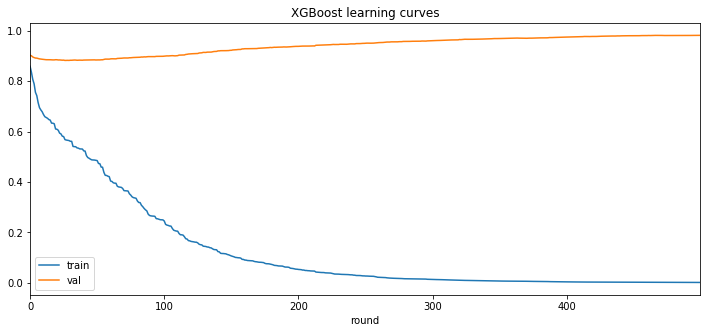

In [92]:
# https://www.youtube.com/watch?v=s3VmuVPfu0s

evals_result = clf.evals_result()
train_errors = evals_result['validation_0']['f1_err']
val_errors = evals_result['validation_1']['f1_err']
df = pd.DataFrame([train_errors, val_errors]).T
df.columns = ['train', 'val']
df.index.name = 'round'
df.plot(title='XGBoost learning curves', figsize=(12, 5))

# Random forest imbalanced also without dask

In [46]:
BalancedRandomForestClassifier??

In [22]:
clf = BalancedRandomForestClassifier(n_jobs=20, class_weight='balanced')

In [23]:
clf.fit(X_train_split_numpy, y_train_split_numpy)

BalancedRandomForestClassifier(bootstrap=True, class_weight='balanced',
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=20, oob_score=False, random_state=None,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [24]:
y_val_pred_numpy = clf.predict(X_val_split_numpy)
cf = confusion_matrix(y_val_split_numpy, y_val_pred_numpy)
print(cf)

print('F1 score: ', f1_score(y_val_split_numpy, y_val_pred_numpy))

[[210102 275342]
 [  7962  16861]]
F1 score:  0.10636982455697638


# Submission

In [56]:
def write_submission(filename, y_pred):
    df = pd.DataFrame(y_pred, columns=['Target'])
    df.index.name = 'Id'
    print(df.Target.value_counts())
    df.to_csv(filename)

In [48]:
pipeline = Pipeline([
    ('std', StandardScaler()),
    ('clf', SGDClassifier(random_state=0, tol=1e-04, **gs.best_params_))
])

with ProgressBar():
    pipeline.fit(X_train_arr, y_train_arr)


In [59]:
pipeline['clf']

SGDClassifier(alpha=0.1, average=False,
              class_weight={0: 0.5256760365234032, 1: 10.23670526493175},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
gs.best_params_

{'alpha': 0.1,
 'class_weight': {0: 0.5256760365234032, 1: 10.23670526493175},
 'loss': 'hinge'}

In [54]:
y_test_pred = pipeline.predict(X_test_arr)

In [57]:
write_submission(join(DATA_PATH, 'first_submission.csv'), y_test_pred)

1    474335
0    234704
Name: Target, dtype: int64


Score on LB: 0.16634